In [ ]:
!pip install -U scikit-learn -i https://pypi.tuna.tsinghua.edu.cn/simple

In [23]:
import tensorflow as tf
import api.capital_features_api as cf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

tf.config.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
train_data = cf.get_train_data(cf.prod_train_data_url, train_config_id=35602)
validation_data = cf.get_train_data(cf.prod_train_data_url, train_config_id=35603)

In [3]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data['featuresT'], train_data['upSignals']))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data['featuresT'], validation_data['upSignals']))
BATCH_SIZE = 64  # 你可以根据需要调整这个值
train_dataset = train_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

In [8]:
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data['upSignals']),
    y=train_data['upSignals']
)
class_weights = dict(zip(np.unique(train_data['upSignals']), weights))

In [31]:
model = Sequential([
    InputLayer(input_shape=(6, 11)),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
])
model.summary()
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='acc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 6, 128)            71680     
                                                                 
 dropout_11 (Dropout)        (None, 6, 128)            0         
                                                                 
 batch_normalization_4 (Batc  (None, 6, 128)           512       
 hNormalization)                                                 
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                      

In [32]:
his_up = model.fit(train_dataset, epochs=20, validation_data=validation_dataset, verbose=1,
                   callbacks=[early_stopping, reduce_lr], class_weight=class_weights)

Epoch 1/20
320/320 [==============================] - 9s 19ms/step - loss: 0.7034 - acc: 0.5456 - precision: 0.4480 - recall: 0.5450 - val_loss: 0.7038 - val_acc: 0.5421 - val_precision: 0.5007 - val_recall: 0.1499 - lr: 0.0010
Epoch 2/20
320/320 [==============================] - 5s 16ms/step - loss: 0.6864 - acc: 0.5488 - precision: 0.4552 - recall: 0.6009 - val_loss: 0.7169 - val_acc: 0.5074 - val_precision: 0.4711 - val_recall: 0.6145 - lr: 0.0010
Epoch 3/20
320/320 [==============================] - 5s 16ms/step - loss: 0.6774 - acc: 0.5630 - precision: 0.4700 - recall: 0.6517 - val_loss: 0.9491 - val_acc: 0.5449 - val_precision: 0.5074 - val_recall: 0.2261 - lr: 0.0010
Epoch 4/20
320/320 [==============================] - 5s 16ms/step - loss: 0.6691 - acc: 0.5662 - precision: 0.4738 - recall: 0.6787 - val_loss: 0.8373 - val_acc: 0.5258 - val_precision: 0.4777 - val_recall: 0.3752 - lr: 0.0010
Epoch 5/20
320/320 [==============================] - 5s 17ms/step - loss: 0.6652 - acc:

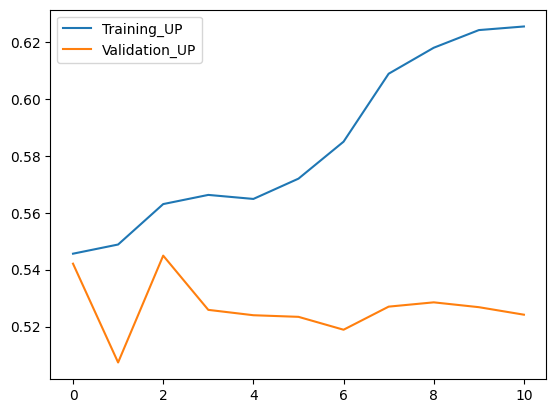

In [33]:
plt.plot(his_up.history['acc'], label='Training_UP')
plt.plot(his_up.history['val_acc'], label='Validation_UP')
plt.legend()
plt.show()

In [ ]:
len(train_data['upSignals'])

In [ ]:
train_data['upSignals'].count(1)

In [ ]:
train_data['upSignals'].count(0)